# Main execution

## IR part|

In [3]:
import pandas as pd
from pandas.core.common import flatten
import numpy as np
import json
from scipy.linalg import svd
from tqdm import tqdm
import pickle
import os
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.pipeline import Pipeline
### NLTK Preprocessing
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')
stop_words = set(stopwords.words('english'))


"""
-----------------------------------------------------------------------------------------
Document indexes
-----------------------------------------------------------------------------------------
"""
def create_doc_index(corpus):
    """Creates doc index"""

    doc_ind = {}
    for i,doc in enumerate(corpus):
        doc_ID = "doc" + str(i)
        doc_ind[doc_ID] = doc

    return doc_ind

def create_doc_map(corpus):
    """creates dict mapping doc to integer"""

    doc_map={}
    for i,doc in enumerate(corpus):
        doc_map[i] = doc
    return doc_map

"""
Inverted dict lookup
"""
def get_key(dict, val):
    for key, value in dict.items():
        if val == value:
            return key
 
    return "key doesn't exist"

"""
-----------------------------------------------------------------------------------------
Term indexes
-----------------------------------------------------------------------------------------
"""
def create_vocab(corpus):
    """creates vocabulary of unique words in corpus"""

    vocab = []
    for doc in corpus:
        for sent in doc:
            for w in sent:
                if w not in vocab:
                    vocab.append(w)

    return vocab

def create_term_index(vocab):
    """creates term index mapping each term to an integer"""

    term_index={}
    for i,word in enumerate(vocab):
        term_index[word] = i

    return term_index


"""
-----------------------------------------------------------------------------------------
Building TD matrix
-----------------------------------------------------------------------------------------
"""
def fast_td(corpus, vocab):
    """ basically fast td array """

    total_terms = len(vocab)
    total_docs = len(corpus)
    td_matrix = np.zeros((total_terms, total_docs))
    doc_map = create_doc_map(corpus)
    term_map = create_term_index(vocab)

    for doc in corpus:
        j = get_key(doc_map, doc)
        for sent in doc:
            for word in sent:
                if word in vocab:
                    i = term_map[word]
                    td_matrix[i,j]+=1   

    return td_matrix 


"""
-----------------------------------------------------------------------------------------
Building TFIDF
-----------------------------------------------------------------------------------------
"""
def tfidf_matrix(corpus):
  """
  creates tfidf matrix from given corpus with terms as rows and documents as columns
  returns tfidf matrix and term_idf column
  """

  corpus = corpus
  vocab = create_vocab(corpus)
  c_array = fast_td(corpus, vocab)
#   c_comp = np.zeros(shape = (c_array.shape[0], c_array.shape[1]+2))
#   c_comp[:, :-2] = c_array

  ni = np.sum((c_array > 0), axis=1)
  term_idf = np.log10(c_array.shape[1]+1) - np.log10(ni+1) + 1
#   c_comp[:, -2] = ni
#   c_comp[:, -1] = term_idf    

  tfidf_matrix = np.multiply(c_array, term_idf.reshape(-1,1))
  return tfidf_matrix, term_idf


def normalize(tfidf_mat):
    """normalizes tfidf matrices for cosine_similarity later"""

    for i in range(tfidf_mat.shape[1]):
        tfidf_mat[:,i] = tfidf_mat[:,i] / (np.linalg.norm(tfidf_mat[:,i]) + 5e-7)

    return tfidf_mat



"""
-----------------------------------------------------------------------------------------
Query processing
-----------------------------------------------------------------------------------------
"""
def create_query_index(corpus):
    """Creates query index"""

    query_ind = {}
    for i,query in enumerate(corpus):
        query_ID = "query" + str(i)
        query_ind[query_ID] = query

    return query_ind

def query_proc(query_corp, doc_tfidf, doc_vocab, term_idf):
    """accepts queries as lists of lists - treated like documents
       query index, tf dataframe and tfidf matrix created   
    """

    query_ind = create_query_index(query_corp) ### {q0 - [[]], q1 - [[]]} type of indexing
    query_td_arr = fast_td(query_corp, doc_vocab)
    query_tfidf = np.multiply(query_td_arr, term_idf.reshape(-1,1))

    return query_tfidf, query_ind


"""
-----------------------------------------------------------------------------------------
Ranking
-----------------------------------------------------------------------------------------
"""
def ranking(query_tfidf, doc_tfidf, k):
    """produces the top k relevant documents per query"""  

    norm_qt = normalize(query_tfidf)
    norm_doct = normalize(doc_tfidf)

    """Ranking by cosine sim and argsort, then picking top 3 relevant docs"""    
    cosine_sim_matrix = norm_qt.T@norm_doct
    ind = np.argsort(cosine_sim_matrix, axis=1)
    
    best_match = np.fliplr(ind[:, -k:])
    ind_list = best_match.tolist()

    return ind_list

In [ ]:

from native_preprocessor import native_prep
native_prep = native_prep()

def load_json_files():
    # Read queries
    queries_json = json.load(open(main_path + "cran_queries.json", 'r'))[:]
    query_ids, queries = [item["query number"] for item in queries_json], \
                            [item["query"] for item in queries_json]
    # Process queries 
    processedQueries = native_prep.preprocessQueries(queries)

    processedQueries = processedQueries[:]
    # print(processedQueries)

    # Read documents
    docs_json = json.load(open(main_path + "cran_docs.json", 'r'))[:]
    doc_ids, docs = [item["id"] for item in docs_json], \
                            [item["body"] for item in docs_json]
    # Process documents
    processedDocs = native_prep.preprocessDocs(docs)
    # print(processedDocs[0])

    ### to resolve num1 discrepancy:
    query_ids = list(np.array(query_ids)-1)
    doc_ids = list(np.array(doc_ids)-1)    
    return processedQueries, processedDocs, query_ids, doc_ids

proc_queries, proc_docs, query_ids, doc_ids = load_json_files()


def searchDataset(processedQueries, processedDocs, k):
    """
    - preprocesses the queries and documents, stores in output folder
    - invokes the IR system
    - evaluates precision, recall, fscore, nDCG and MAP 
        for all queries in the Cranfield dataset
    - produces graphs of the evaluation metrics in the output folder
    """
    
    doc_index = create_doc_index(processedDocs)
    # print(herb_doc_index)
    # herb_term_index = create_term_index(processedDocs) 
    # print(herb_term_index)
    doc_vocab = create_vocab(processedDocs)
    # print(herb_vocab)
    doc_tfidf, doc_term_idf = tfidf_matrix(processedDocs)
    # print(herb_tfidf_mat[:20, :20])
    query_tfidf, query_index = query_proc(processedQueries, doc_tfidf, doc_vocab, doc_term_idf)
    # print(herb_query_tfidf.sum())
    doc_best = ranking(query_tfidf, doc_tfidf, k)
    return doc_best

doc_ids_ordered = searchDataset(proc_queries, proc_docs, 10)

query_index = create_query_index(proc_queries)
doc_index = create_doc_index(proc_docs)
query_num_list = list(range(225))
# display_query_match(query_num_list, query_index, doc_ids_ordered, doc_index)
# print(doc_ids_ordered) #should be total no of queries - 225

## Evaluation part

In [5]:
qrels = json.load(open(main_path + "cran_qrels.json", 'r'))[:]

from big_true_IDs import big_true_IDs
big_true_IDs_ob = big_true_IDs()
big_true_IDs = big_true_IDs_ob.big_true_IDs(qrels)    

### Plotting metrics

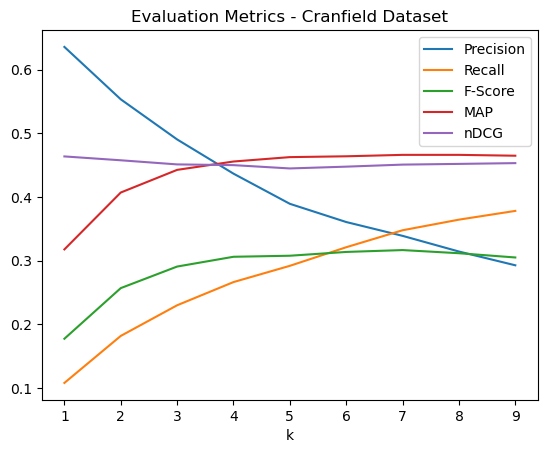

In [6]:
query_ids = list(range(225))

from plotting import plotting
plot_ob = plotting()
plot_ob.plot_measures(doc_ids_ordered, query_ids, big_true_IDs, qrels, 10)

### Underperforming query matches

In [7]:
from check_matches import Check_matches
check_matches = Check_matches()

bqi = check_matches.check_queries(doc_ids_ordered, query_ids, big_true_IDs, qrels, 10)
print("------------------------------------------------")
print("Number of queries with 0 precision - ", len(bqi))
print("Query IDs - ", bqi)
print("------------------------------------------------")
query_index = check_matches.create_query_index(proc_queries)
doc_index = check_matches.create_doc_index(proc_docs)
check_matches.display_query_match(bqi, query_index, doc_ids_ordered, doc_index)


------------------------------------------------
Number of queries with 0 precision -  20
Query IDs -  [4, 8, 18, 21, 27, 34, 43, 61, 62, 71, 73, 84, 109, 114, 115, 150, 151, 166, 206, 215]
------------------------------------------------
for query_num =  4

query :  [['chemical', 'kinetic', 'system', 'applicable', 'hypersonic', 'aerodynamic', 'problem']]

------------------------------------------------------------------------------------
rank 1 : doc358

[['note', 'hypersonic', 'similarity', 'law', 'unyawed', 'cone'], ['known', 'hypersonic', 'similarity', 'law', 'derived', 'slender', 'cone', 'ogival', 'body', 'assumption', 'applicable', 'mach', 'number', 'low', '3'], ['note', 'make', 'use', 'series', 'development', 'infer', 'hypersonic', 'similarity', 'law', 'unyawed', 'cone', 'taylor-maccoll', 'differential', 'equation', 'associated', 'boundary', 'condition'], ['simple', 'approximate', 'formula', 'function', 'similarity', 'law', 'obtained', 'drag', 'function', 'computed', 'formula',